# FITTING A BOND YIELD CURVE

In this notebook I show how you can build a yield curve and fit it parametrically using a number of curve functions

In [1]:
import datetime as dt
import pandas as pd

In [2]:
from financepy.finutils import *
from financepy.products.bonds import *
from financepy.market.curves import *

####################################################################
# FINANCEPY BETA Version 0.180 - This build:  22 Sep 2020 at 22:58 #
#      This software is distributed FREE & WITHOUT ANY WARRANTY    #
# For info and disclaimer - https://github.com/domokane/FinancePy  #
#    For bug reports and comments - allmypythonprojects@gmail.com  #
####################################################################



## Load Bond Data

I have downloaded some bond price data from the UK DMO

In [3]:
bondDataFrame = pd.read_csv('./data/giltbondprices.txt', sep='\t')

We'll use mid-market prices for our analysis

In [4]:
bondDataFrame['mid'] = 0.5*(bondDataFrame['bid'] + bondDataFrame['ask'])

We need to use UK bond conventions

In [5]:
accrualType, frequencyType, settlementDays = getTreasuryBondMarketConventions(FinBondMarkets.UNITED_KINGDOM)

In [6]:
today = FinDate(18,9,2012)
settlementDate = today.addWorkDays(settlementDays)
print("Settles:", settlementDate)

Settles: WED 19 SEP 2012


In [7]:
bonds = []
ylds = []

In [10]:
for index, bond in bondDataFrame.iterrows():

    dateString = bond['maturity']
    matDatetime = dt.datetime.strptime(dateString, '%d-%b-%y')
    maturityDt = fromDatetime(matDatetime)
    issueDt = FinDate(maturityDt._d, maturityDt._m, 2000)
    coupon = bond['coupon']/100.0
    cleanPrice = bond['mid']
    bond = FinBond(issueDt, maturityDt, coupon, frequencyType, accrualType)
    yld = bond.yieldToMaturity(settlementDate, cleanPrice)
    bonds.append(bond)
    ylds.append(yld)

## Yield Curve Fitting

### Cubic Polynomial Curve

We can fit the yields to a polynomial. The default is a cubic so no argument is needed. 

In [11]:
curveFunction = FinCurveFitPolynomial()

In [12]:
fittedCurve = FinBondYieldCurve(settlementDate, bonds, ylds, curveFunction)

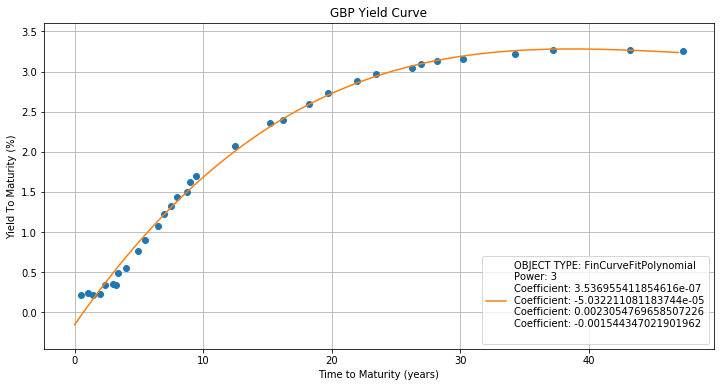

In [13]:
fittedCurve.plot("GBP Yield Curve")

We can get the coefficients as follows

In [13]:
curveFunction._coeffs

array([ 3.53695541e-07, -5.03221108e-05,  2.30547697e-03, -1.54434702e-03])

These coefficients start with the highest power of the time to maturity and end with the constant 

To get a specific yield we can call the function interpolatedYield

In [14]:
fittedCurve.interpolatedYield(20.0)*100

2.7265912299887343

In [15]:
times = np.linspace(0,10,10)

In [16]:
fittedCurve.interpolatedYield(times)*100

array([-0.1544347 ,  0.09556532,  0.33343123,  0.55945415,  0.77392517,
        0.97713542,  1.16937598,  1.35093798,  1.52211252,  1.68319071])

### Quintic Polynomial

We can add more parameters using a Quintic polynomial.

In [17]:
curveFunction = FinCurveFitPolynomial(5)

In [18]:
fittedCurve = FinBondYieldCurve(settlementDate, bonds, ylds, curveFunction)

In [19]:
curveFunction._coeffs

array([-1.44771535e-09,  1.78395721e-07, -7.41468170e-06,  9.06222841e-05,
        1.35360732e-03,  4.15140087e-07])

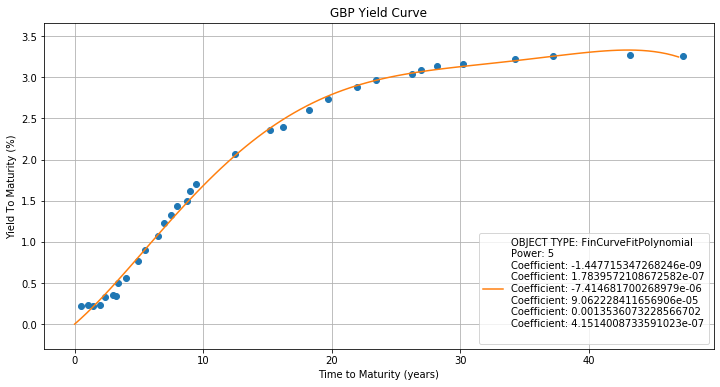

In [20]:
fittedCurve.plot("GBP Yield Curve")

The fit is slightly better.

Vectorisation works

In [21]:
fittedCurve.interpolatedYield(times)*100

array([4.15140087e-05, 1.60640106e-01, 3.37885261e-01, 5.26616437e-01,
       7.22266817e-01, 9.20833892e-01, 1.11885004e+00, 1.31335309e+00,
       1.50185693e+00, 1.68232208e+00])

### Nelson-Siegel Parametric Curve

We can fit the bond yields using the Nelson-Siegel curve

In [22]:
curveFunction = FinCurveFitNelsonSiegel()

In [23]:
fittedCurve = FinBondYieldCurve(settlementDate, bonds, ylds, curveFunction)

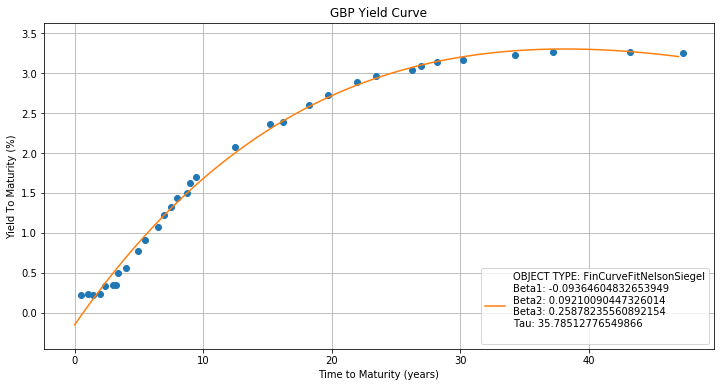

In [24]:
fittedCurve.plot("GBP Yield Curve")

We can access the underlying Nelson-Siegel parameters

In [25]:
print("beta1 %12.8f"% curveFunction._beta1)
print("beta2 %12.8f"% curveFunction._beta2)
print("beta3 %12.8f"% curveFunction._beta3)
print("tau   %12.8f"% curveFunction._tau)

beta1  -0.09364605
beta2   0.09210090
beta3   0.25878236
tau    35.78512777


Vectorisation works

In [26]:
fittedCurve.interpolatedYield(times)*100

array([-0.15483615,  0.0975029 ,  0.33634955,  0.56251205,  0.77646044,
        0.9786489 ,  1.16951625,  1.34948644,  1.51896903,  1.67835968])

### Nelson-Siegel-Svensson Parametric Curve

There are two more parameters in this parametric curve.

In [27]:
curveFunction = FinCurveFitNelsonSiegelSvensson()

In [28]:
fittedCurve = FinBondYieldCurve(settlementDate, bonds, ylds, curveFunction)

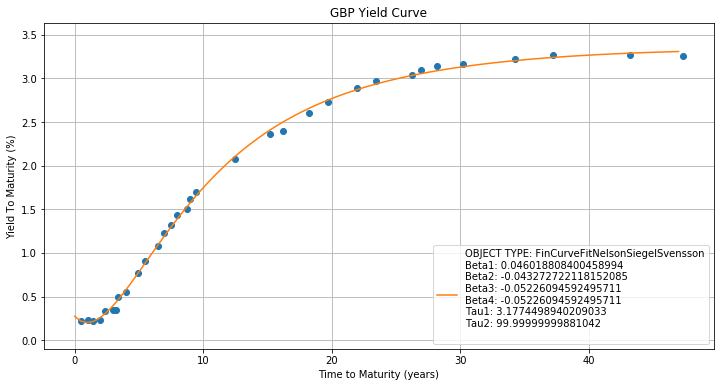

In [29]:
fittedCurve.plot("GBP Yield Curve")

Once again we can access the parameters

In [30]:
print("beta1 %12.8f"% curveFunction._beta1)
print("beta2 %12.8f"% curveFunction._beta2)
print("beta3 %12.8f"% curveFunction._beta3)
print("beta4 %12.8f"% curveFunction._beta4)
print("tau1  %12.8f"% curveFunction._tau1)
print("tau2  %12.8f"% curveFunction._tau2)

beta1   0.04601881
beta2  -0.04327272
beta3  -0.05226095
beta4  -0.03756484
tau1    3.17744989
tau2  100.00000000


Internally I have imposed a bound of [1,100] on tau2. I can override this. This is what is used internally.

In [31]:
bounds = [(0, -1, -1, -1, 0, 1), (1, 1, 1, 1, 10, 100)]

I change it to

In [32]:
bounds = [(0, -1, -1, -1, 0, 1), (1, 1, 1, 1, 10, 1000)]

In [33]:
curveFunction = FinCurveFitNelsonSiegelSvensson(bounds=bounds)

In [34]:
fittedCurve = FinBondYieldCurve(settlementDate, bonds, ylds, curveFunction)

In [35]:
print("beta1 %12.8f"% curveFunction._beta1)
print("beta2 %12.8f"% curveFunction._beta2)
print("beta3 %12.8f"% curveFunction._beta3)
print("beta4 %12.8f"% curveFunction._beta4)
print("tau1  %12.8f"% curveFunction._tau1)
print("tau2  %12.8f"% curveFunction._tau2)

beta1   0.04430038
beta2  -0.04153520
beta3  -0.05107468
beta4  -0.22564923
tau1    3.13419388
tau2  999.99999994


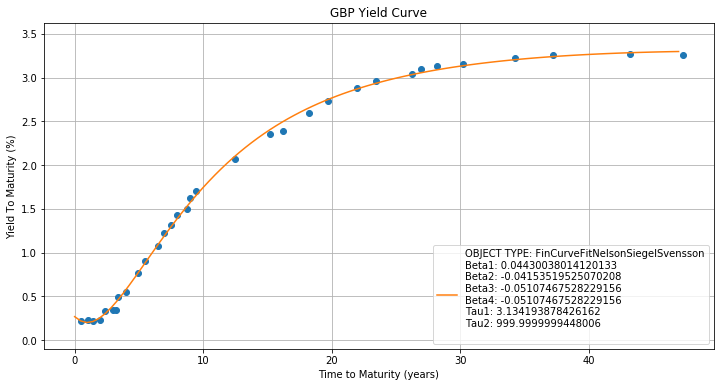

In [36]:
fittedCurve.plot("GBP Yield Curve")

It is clear that the parameter tau2 wants to head to infinity - reducing to the Nelson-Siegel parametrisation.

Vectorisation works

In [37]:
fittedCurve.interpolatedYield(times)*100

array([0.26949811, 0.20311554, 0.28484326, 0.45424339, 0.66787302,
       0.89835085, 1.12894733, 1.34992069, 1.55604864, 1.74497608])

### B-Splines

Splines give us more flexibility and ensure smoothness. Internally I put knots at 1, 3, 5 and 10 years. 

In [38]:
curveFunction = FinCurveFitBSpline()
fittedCurve = FinBondYieldCurve(settlementDate, bonds, ylds, curveFunction)

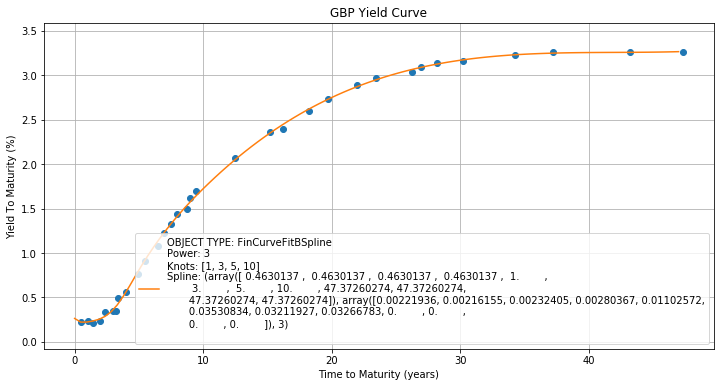

In [39]:
fittedCurve.plot("GBP Yield Curve")

We can recover the parameters of the spline.

In [40]:
curveFunction._spline

(array([ 0.4630137 ,  0.4630137 ,  0.4630137 ,  0.4630137 ,  1.        ,
         3.        ,  5.        , 10.        , 47.37260274, 47.37260274,
        47.37260274, 47.37260274]),
 array([0.00221936, 0.00216155, 0.00232405, 0.00280367, 0.01102572,
        0.03530834, 0.03211927, 0.03266783, 0.        , 0.        ,
        0.        , 0.        ]),
 3)

Vectorisation works.

In [41]:
fittedCurve.interpolatedYield(times)*100

array([0.26306369, 0.22601011, 0.27452407, 0.4183769 , 0.6700895 ,
       0.93767122, 1.1718964 , 1.37665168, 1.55813287, 1.72253582])

You can change the power of the spline

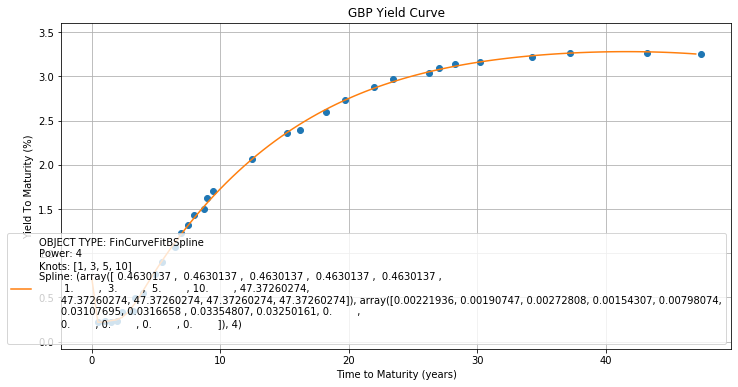

In [42]:
curveFunction = FinCurveFitBSpline(4)
fittedCurve = FinBondYieldCurve(settlementDate, bonds, ylds, curveFunction)
fittedCurve.plot("GBP Yield Curve")

This may not be what you want ! Let's see if 5 is better.

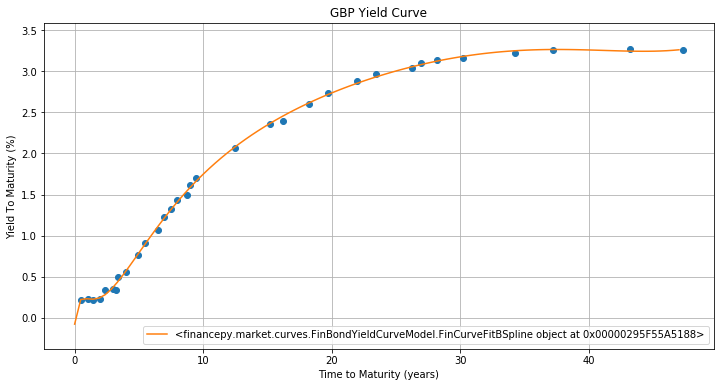

In [45]:
curveFunction = FinCurveFitBSpline(5)
fittedCurve = FinBondYieldCurve(settlementDate, bonds, ylds, curveFunction)
fittedCurve.plot("GBP Yield Curve")

Probably best to stick with a cubic B-spline.

## Inspecting the curve object


For each curve type you can examine the inner details of the calibration

In [47]:
fittedCurve._curveFit._knots

[1, 3, 5, 10]

In [53]:
fittedCurve._curveFit._power

5

In [54]:
fittedCurve._curveFit._spline

(array([ 0.46270692,  0.46270692,  0.46270692,  0.46270692,  0.46270692,
         0.46270692,  1.        ,  3.        ,  5.        , 10.        ,
        47.34121487, 47.34121487, 47.34121487, 47.34121487, 47.34121487,
        47.34121487]),
 array([0.00221936, 0.00237133, 0.0023876 , 0.00171554, 0.00506514,
        0.02909382, 0.0270327 , 0.03659002, 0.03131557, 0.03266729,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ]),
 5)

Copyright (c) 2019, Dominic O'Kane 